In [1]:
from neuron import h
h.nrn_load_dll("/Users/lillikiessling/Documents/Stanford/Code/BC_model/Ion_channels/arm64/libnrnmech.dylib")
h.load_file('stdrun.hoc') 
import numpy as np
import matplotlib.pyplot as plt
import time as _time
import helperFuns as hF

--No graphics will be displayed.


# Parameters

In [2]:
# ON Type Bipolar Cell Model

# ======= Ion Channel Types=======
# HCN1: 'Bip_HCN1'
# HCN2: 'Bip_HCN2'
# HCN4: 'Bip_HCN4'
# CaL : 'Bip_CaL'
# CaT : 'Bip_CaT'
# KCa: 'Bip_KCa' -> must come with 'Bip_caconc' 
# Kir: 'Bip_Kir'
# Kv: 'Bip_Kv'
# Na: 'Bip_Na'


# ======= Reversal Potentials =======
eh = -45 # mV
ek = -58 # mV
ena = 57.016 # mV
# eca = eca (default neuron)


# ======= Locations (from Thesis Havel Benav) =======
# HCN1: term, soma
# HCN2: term, soma
# HCN4: term 
# CaL : soma
# CaT : soma
# KCa: soma
# Kir: soma
# Kv: soma
# Na: term, soma, dendrites


# ======= Morphology (From Paul Werginz model) =======
dXdend = 5  # max. compartment length dendrite (um)
dXaxon = 2  # max. compartment length axon (um)
dXterm = 1  # max. compartment length terminals (um)
rhoA = 132  # intracellular (axial) resistivity (Ohm*cm)
cM = 1.14  # specific membrane capcitance (uF/cm2)
eL = -50  # Leak reversal potential (mV)
temp = 35  # temperature (Celsius)
glbar = 0.04166 # specific leak conductance (S/cm2)



# Model

ON Bipolar Cell (BC_Euler9_ON morphology)
  Total sections: 32
  Total segments: 132
  Position: (10, 5, 2)
  Rotation (Z-axis): 45.0°
  Temperature: 35.0°C
  Passive leak: g_pas=0.04166 S/cm2, e_pas=-50.0 mV


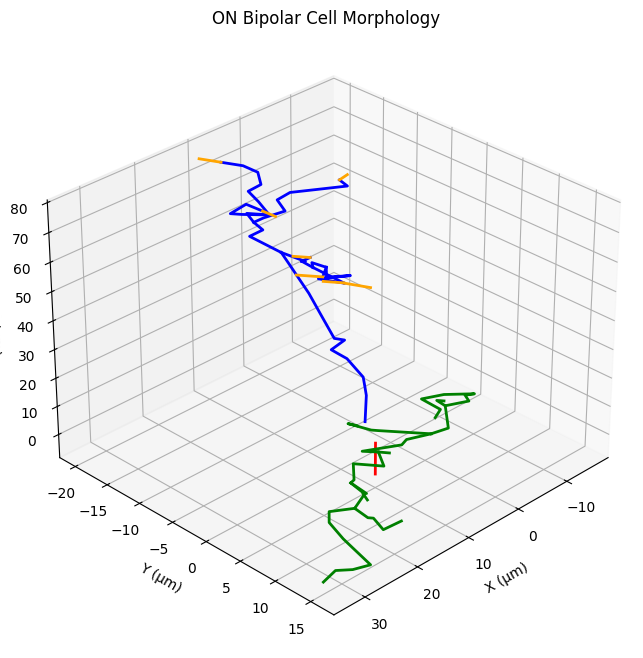

In [3]:
# ON-type Bipolar Cell model (using nrn/cells/BC_Euler9_ON morphology)
h.load_file("stdrun.hoc")
h.load_file("nrn/cells/BC_Euler9_ON.hoc")  # adjust path if needed


class ONBipolarCell:
    """
    ON-type Bipolar Cell based on BC_Euler9_ON morphology and ion channel distribution.
    Conductances are defined in .mod files.
    """

    def __init__(self, Stim=None):
        # ==== Constants ====
        self.dXdend = 5.0   # µm
        self.dXaxon = 2.0   # µm
        self.dXterm = 1.0   # µm
        self.rhoA = 132.0   # Ohm*cm
        self.cM = 1.14      # µF/cm2
        self.eL = -50.0     # mV
        self.glbar = 0.04166  # S/cm2
        self.temp = 35.0     # °C

        # reversal potentials
        self.eh = -45.0
        self.ek = -58.0
        self.ena = 57.016

        # temperature
        h.celsius = self.temp

        # ==== Load morphology from hoc template ====
        self.cell = h.BC_Euler9_ON()
        self.soma = self.cell.soma
        self.dendritic = self.cell.dendritic
        self.axonal = self.cell.axonal
        self.terminal = self.cell.terminal
        self.all = self.cell.all

        # ==== Set up morphology and biophysics ====
        self._set_nseg()
        self._set_passive()
        self._insert_channels()

        # ==== Set cell position & rotation ====
        self.x = 0
        self.y = 0
        self.z = 0
        self.theta = 0  # rotation

        if Stim is not None:
            self._set_position(Stim)
            if 'theta' in Stim:
                self._rotateZ(Stim['theta'])

    # --------------------------------------------------
    def _set_nseg(self):
        """Segment each section according to maximum compartment length rules."""
        for sec in self.all:
            if "dend" in sec.name():
                sec.nseg = int(np.ceil(sec.L / self.dXdend))
            elif "axon" in sec.name():
                sec.nseg = int(np.ceil(sec.L / self.dXaxon))
            elif "term" in sec.name():
                sec.nseg = int(np.ceil(sec.L / self.dXterm))
            else:
                sec.nseg = 1  # soma
        # optional: print segment counts
        # for sec in self.all:
        #     print(f"{sec.name()} nseg={sec.nseg}")

    # --------------------------------------------------
    def _set_passive(self):
        """Assign passive properties."""
        for sec in self.all:
            sec.Ra = self.rhoA
            sec.cm = self.cM
            sec.insert("pas")
            sec.g_pas = self.glbar
            sec.e_pas = self.eL

    # --------------------------------------------------
    def _insert_channels(self):
        """Insert active conductances at appropriate locations."""
        # --- soma ---
        sec = self.soma
        sec.insert("Bip_HCN1")
        sec.insert("Bip_HCN2")
        sec.insert("Bip_CaL")
        sec.insert("Bip_CaT")
        sec.insert("Bip_caconc")
        sec.insert("Bip_KCa")
        sec.insert("Bip_Kir")
        sec.insert("Bip_Kv")
        sec.insert("Bip_Na")
        sec.eh = self.eh
        sec.ek = self.ek
        sec.ena = self.ena

        # --- dendrites ---
        for sec in self.dendritic:
            sec.insert("Bip_Na")
            sec.ena = self.ena

        # --- axon ---
        for sec in self.axonal:
            sec.insert("Bip_Na")
            sec.ena = self.ena

        # --- terminals ---
        for sec in self.terminal:
            sec.insert("Bip_HCN1")
            sec.insert("Bip_HCN2")
            sec.insert("Bip_HCN4")
            sec.insert("Bip_Na")
            sec.eh = self.eh
            sec.ena = self.ena

    # ----------------------------
    def _set_position(self, Stim):
        """Shift cell to (x, y, z) location specified in Stim dictionary."""
        self.x = Stim.get('x', 0)
        self.y = Stim.get('y', 0)
        self.z = Stim.get('z', 0)
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i,
                               sec.x3d(i) + self.x,
                               sec.y3d(i) + self.y,
                               sec.z3d(i) + self.z,
                               sec.diam3d(i))

    # ----------------------------
    def _rotateZ(self, theta):
        """Rotate cell around z-axis by theta (radians)."""
        self.theta = theta
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i) - self.x
                y = sec.y3d(i) - self.y
                xprime = x * np.cos(theta) - y * np.sin(theta)
                yprime = x * np.sin(theta) + y * np.cos(theta)
                sec.pt3dchange(i, xprime + self.x, yprime + self.y, sec.z3d(i), sec.diam3d(i))


    # --------------------------------------------------
    def info(self):
        nsec = len(list(self.all))
        nseg = sum(sec.nseg for sec in self.all)
        print(f"ON Bipolar Cell (BC_Euler9_ON morphology)")
        print(f"  Total sections: {nsec}")
        print(f"  Total segments: {nseg}")
        print(f"  Position: ({self.x}, {self.y}, {self.z})")
        print(f"  Rotation (Z-axis): {np.degrees(self.theta)}°")
        print(f"  Temperature: {self.temp}°C")
        print(f"  Passive leak: g_pas={self.glbar} S/cm2, e_pas={self.eL} mV")

    # --------------------------------------------------
    def sections(self):
        return list(self.all)

def plot_cell(cell):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Colors for different parts
    colors = {'soma':'red', 'dend':'green', 'axon':'blue', 'term':'orange'}

    for sec in cell.all:
        x = [sec.x3d(i) for i in range(sec.n3d())]
        y = [sec.y3d(i) for i in range(sec.n3d())]
        z = [sec.z3d(i) for i in range(sec.n3d())]
        # Determine color
        if 'soma' in sec.name():
            c = colors['soma']
        elif 'dend' in sec.name():
            c = colors['dend']
        elif 'axon' in sec.name():
            c = colors['axon']
        elif 'term' in sec.name():
            c = colors['term']
        else:
            c = 'black'
        ax.plot(x, y, z, c=c, linewidth=2)

    ax.set_xlabel('X (µm)')
    ax.set_ylabel('Y (µm)')
    ax.set_zlabel('Z (µm)')
    ax.set_title('ON Bipolar Cell Morphology')
    ax.view_init(elev=30, azim=45)
    plt.show()


# Example usage
if __name__ == "__main__":
    Stim = {'x': 10, 'y': 5, 'z': 2, 'theta': np.pi/4}  
    cell = ONBipolarCell(Stim)
    cell.info()
    plot_cell(cell)

# Stim

In [19]:
# ======= Initialize Stimulus =========
Stim = {}   

# General 
Stim['ID'] = 1  # cell ID, see 'bcTemplate.py' for details
Stim['reset'] = 1  # flag whether previously created cells should be deleted ('1' or '0') 
Stim['vInit'] = -50  # membrane potential to initialize model (mV)
Stim['type'] = 'iClamp'  # type of stimulation ('extracellular', 'iClamp')
Stim['amp'] = 1  # stimulus amplitude (pA for 'iClamp', uA for 'extracellular')
# Extracellular
Stim['elec'] = 'point'  # electrode type ('point' or 'disk'), for 'extracellular' only
Stim['rDisk'] = 20  # electrode radius um, for 'disk' only
Stim['rhoExt'] = 1000  # extracellular resisitivity (Ohm*cm), for 'point' & 'disk' only
Stim['stimXShift'] = 0  # electrode x-shift (um), for 'point' & 'disk' only
Stim['stimYShift'] = 0  # electrode y-shift (um), for 'point' & 'disk' only
Stim['stimZShift'] = 0  # electrode z-shift (um), for 'point' & 'disk' only
Stim['cellXShift'] = 0  # cell x-shift (um)
Stim['cellYShift'] = 0  # cell y-shift (um)
Stim['cellZShift'] = 20  # cell z-shift (um)
Stim['cellZRot'] = 0  # cell z-rotation (deg)

### Temporal parameters
Stim['stop'] = 10  # total duration of simulation (ms)
Stim['dt'] = 0.005  # time step of simulation (ms)
# Initialization
Stim['initDur'] = 200  # duration of initialization procedure (ms)
Stim['initDt'] = 10  # time step of initialization procedure (ms), dt=1e10 computes steady state in one step
# Rectangular pulse
Stim['del'] = 1  # delay until stim is turned on (ms)
Stim['dur'] = 4  # duration of stim (ms)
Stim['pulseShape'] = 'mono'  # pulse shape ('mono' or 'bi')
Stim['pulseRatio'] = [1,-1]  # ratio between leading and balancing pulse, for 'bi' only



# ======= Initialize ON BC-cell =========
cell = ONBipolarCell(Stim)


# ======= Run Stimulation =========
# Set up stimulus
# Temporal properties, i.e. pulse shape
tsvec, isvec = hF.setStimTemp(Stim)
# Type of stimulation 
if Stim['type'] == 'iClamp':
    ic = hF.setStimIClamp(cell)
    isvec.play(ic._ref_amp, tsvec)
elif Stim['type'] == 'extracellular':
    hF.setStimTransferImpedance(Stim, cell)
    isvec.play(h._ref_is_xtra, tsvec, 1)    
else:
    print('--- Unknown stimulus')

#Set up outputs
tRec = h.Vector().record(h._ref_t)
vRecSoma = h.Vector().record(cell.soma(0.5)._ref_v)
icaRecSoma = h.Vector().record(cell.soma(0.5)._ref_ica)
caIRecSoma = h.Vector().record(cell.soma(0.5)._ref_cai)
term_list = [sec for sec in cell.terminal]
vRecTerm = h.Vector().record(term_list[0](0.5)._ref_v)
# icaRecTerm = h.Vector().record(term_list[0](0.5)._ref_ica)
# caIRecTerm = h.Vector().record(term_list[0](0.5)._ref_cai)

# run model
Tic = _time.time()
h.tstop = Stim['initDur']
h.dt = Stim['initDt']
h.finitialize(Stim['vInit'])
h.continuerun(h.tstop)

h.tstop = Stim['initDur'] + Stim['stop']
h.dt = Stim['dt']
h.continuerun(h.tstop)
Toc = _time.time()
print('--- Running the model took %.2f secs' % (Toc - Tic))

--- Running the model took 0.04 secs


# Plots

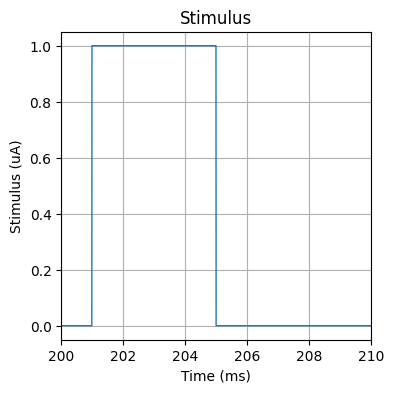

In [40]:
# ======= Plot Stimulus =========
plt.figure(figsize=((4,4)))
plt.grid()
plt.plot(tsvec,isvec*1e3, lw=1)
plt.xlim(Stim['initDur'], Stim['initDur'] + Stim['stop'])
plt.xlabel('Time (ms)')
plt.ylabel('Stimulus (uA)')
plt.title('Stimulus')
plt.show()

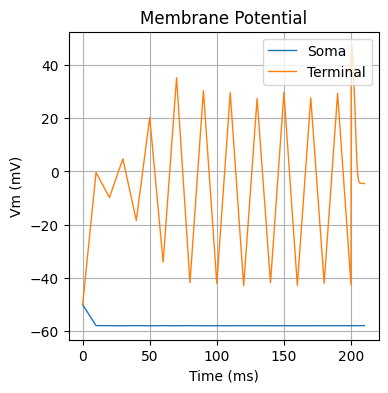

In [38]:
# =========== Membrane voltage over time ===========
plt.figure(figsize=((4,4)))
plt.grid()
# Plot Vm at soma over time
plt.plot(tRec, vRecSoma, lw=1, label='Soma')
plt.plot(tRec, vRecTerm, lw=1, label='Terminal')
plt.legend(loc='upper right')
plt.title('Membrane Potential')
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.show()

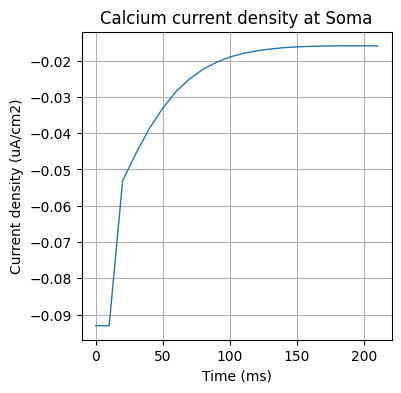

In [37]:
# ========= Calcium current over time =========
plt.figure(figsize=((4,4)))
plt.grid()
# Plot Vm at soma over time
plt.plot(tRec, icaRecSoma*1e3,lw=1)
plt.xlabel('Time (ms)')
plt.ylabel('Current density (uA/cm2)')
plt.title('Calcium current density at Soma')
plt.show()

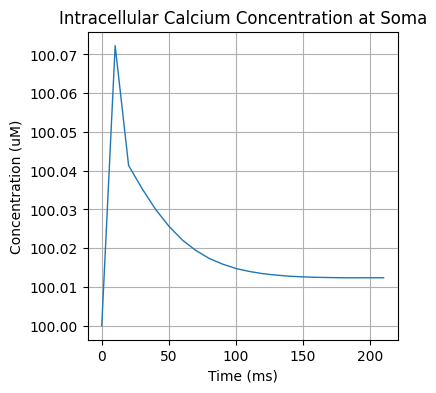

In [ ]:
# ========= Intracellular calcium concentration over time =========
plt.figure(figsize=((4,4)))
plt.grid()
# Plot Vm at soma over time
plt.plot(tRec, caIRecSoma*1e3, lw=1)
plt.xlabel('Time (ms)')
plt.ylabel('Concentration (uM)')
plt.title('Intracellular Calcium Concentration at Soma')
plt.show()